In [55]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein
import re
from rouge_score import rouge_scorer


In [56]:
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

val_data = load_jsonl("../data/t5_results/val_predictions.jsonl")
test_data = load_jsonl("../data/t5_results/test_predictions.jsonl")

print(f"Loaded {len(val_data)} validation and {len(test_data)} test examples")


Loaded 3736 validation and 3736 test examples


In [57]:

def compute_metrics(predictions, references):
    ems = [p == r for p, r in zip(predictions, references)]
    levenshteins = [Levenshtein.ratio(p, r) for p, r in zip(predictions, references)]

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouges = [scorer.score(p, r)['rougeL'].fmeasure for p, r in zip(predictions, references)]

    return {
        "Exact Match": np.mean(ems),
        "Levenshtein Similarity": np.mean(levenshteins),
        "ROUGE-L": np.mean(rouges)
    }

# Validation metrics
val_preds = [ex["prediction"] for ex in val_data]
val_refs = [ex["target"] for ex in val_data]

print("📊 Validation Metrics:")
print(compute_metrics(val_preds, val_refs))

# Test metrics
test_preds = [ex["prediction"] for ex in test_data]
test_refs = [ex["target"] for ex in test_data]

print("\nTest Metrics:")
print(compute_metrics(test_preds, test_refs))


📊 Validation Metrics:
{'Exact Match': 0.6175053533190579, 'Levenshtein Similarity': 0.9781348422048547, 'ROUGE-L': 0.9698366276604463}

Test Metrics:
{'Exact Match': 0.6078693790149893, 'Levenshtein Similarity': 0.9770646463908129, 'ROUGE-L': 0.9666466108242727}


In [58]:
def show_errors(data, n=5):
    count = 0
    for ex in data:
        if ex["prediction"].strip() != ex["target"].strip():
            print(f"\nInput: {ex['input']}")
            print(f"Target: {ex['target']}")
            print(f"Prediction: {ex['prediction']}")
            count += 1
            if count >= n:
                break

print("Sample Errors from Validation:")
show_errors(val_data)

print("\nSample Errors from Test:")
show_errors(test_data)


Sample Errors from Validation:

Input: <B-Autor>Jürgens </B-Autor> / <B-Autor>Klüsener </B-Autor> , <B-Paragraph>§  1890 </B-Paragraph> Rn . <B-Randnummer>5 </B-Randnummer>
Target: Jürgens/Klüsener, § 1890, Rdnr. 5
Prediction: Jürgens/Klüsener,  1890, Rdnr. 5

Input: <B-Gericht>BVerwG </B-Gericht> , Urteil vom <B-Datum>27  .  10  .  2000 </B-Datum> - <B-Aktenzeichen>4  A  18  /  99 </B-Aktenzeichen> - in : <B-Zeitschrift>DVBl </B-Zeitschrift> . <B-Jahr>2001 </B-Jahr> , <B-Seite-Beginn>386 </B-Seite-Beginn> ff
Target: Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 386, 2001
Prediction: Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 366, 2001

Input: <B-Titel>Münch </B-Titel> . <B-Titel>Komm </B-Titel> . / <B-Autor>Henssler </B-Autor> <B-Auflage>5 </B-Auflage> . <B-Auflage>Aufl </B-Auflage> . <B-Paragraph>§  624 </B-Paragraph> <B-Gesetz>BGB </B-Gesetz> Rn . <B-Randnummer>5 </B-Randnummer>
Target: Henssler, Münch Komm, 5 Aufl., BGB, § 624, Rdn

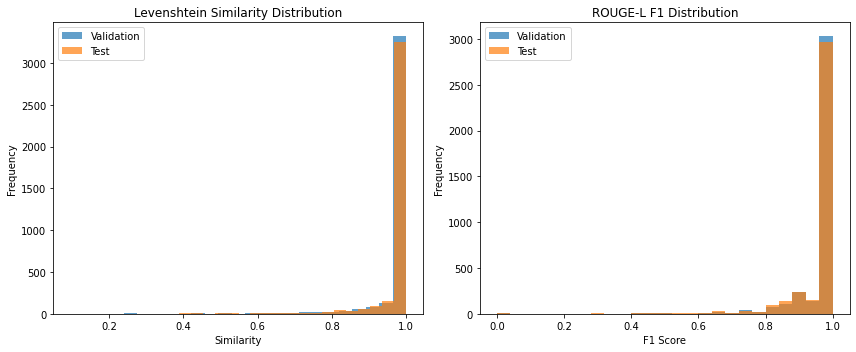

In [59]:
def get_metric_lists(data):
    predictions = [ex["prediction"].strip() for ex in data]
    references = [ex["target"].strip() for ex in data]

    levenshteins = [Levenshtein.ratio(p, r) for p, r in zip(predictions, references)]
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouges = [scorer.score(p, r)['rougeL'].fmeasure for p, r in zip(predictions, references)]
    return levenshteins, rouges

val_lev, val_rouge = get_metric_lists(val_data)
test_lev, test_rouge = get_metric_lists(test_data)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(val_lev, bins=25, alpha=0.7, label='Validation')
plt.hist(test_lev, bins=25, alpha=0.7, label='Test')
plt.title("Levenshtein Similarity Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(val_rouge, bins=25, alpha=0.7, label='Validation')
plt.hist(test_rouge, bins=25, alpha=0.7, label='Test')
plt.title("ROUGE-L F1 Distribution")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/x2/7zjm577917q3bh1bkph8z0wm0000gn/T/ipykernel_15973/760651332.py:19: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/x2/7zjm577917q3bh1bkph8z0wm0000gn/T/ipykernel_15973/760651332.py:19: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 128288 (\N{INPUT SYMBOL FOR LATIN CAPITAL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


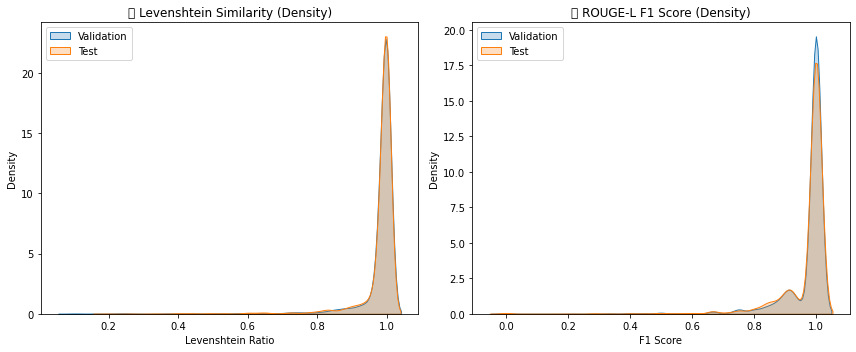

In [60]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(val_lev, label="Validation", fill=True)
sns.kdeplot(test_lev, label="Test", fill=True)
plt.title("🔠 Levenshtein Similarity (Density)")
plt.xlabel("Levenshtein Ratio")
plt.ylabel("Density")
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(val_rouge, label="Validation", fill=True)
sns.kdeplot(test_rouge, label="Test", fill=True)
plt.title("📘 ROUGE-L F1 Score (Density)")
plt.xlabel("F1 Score")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


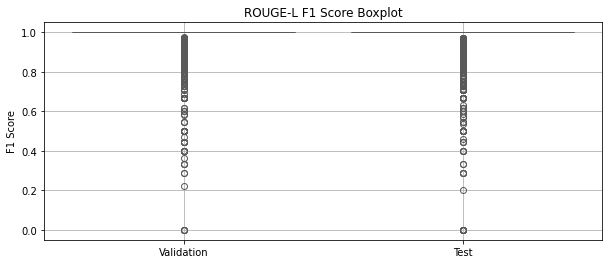

In [61]:
plt.figure(figsize=(10, 4))

sns.boxplot(data=[val_rouge, test_rouge], palette="Set2")
plt.xticks([0, 1], ["Validation", "Test"])
plt.title("ROUGE-L F1 Score Boxplot")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


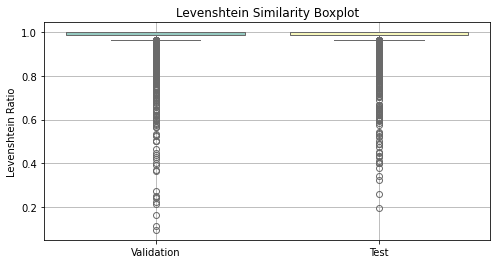

In [62]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=[val_lev, test_lev], palette="Set3")
plt.xticks([0, 1], ["Validation", "Test"])
plt.title("Levenshtein Similarity Boxplot")
plt.ylabel("Levenshtein Ratio")
plt.grid(True)
plt.show()


In [65]:
rows = []
for ex in val_data:
    pred = ex["prediction"].strip()
    target = ex["target"].strip()
    if pred != target:
        rows.append({
            "Raw Input": ex["input"],
            "Rule-based Output (Target)": target,
            "T5 Prediction": pred
        })

df_diff_val = pd.DataFrame(rows)
print(f"{len(df_diff_val)} afwijkende voorspellingen in validation set")
pd.set_option('display.max_colwidth', None)
df_diff_val.head(20)


1429 afwijkende voorspellingen in validation set


,Raw Input,Rule-based Output (Target),T5 Prediction
0,"<B-Autor>Jürgens </B-Autor> / <B-Autor>Klüsener </B-Autor> , <B-Paragraph>§ 1890 </B-Paragraph> Rn . <B-Randnummer>5 </B-Randnummer>","Jürgens/Klüsener, § 1890, Rdnr. 5","Jürgens/Klüsener, 1890, Rdnr. 5"
1,"<B-Gericht>BVerwG </B-Gericht> , Urteil vom <B-Datum>27 . 10 . 2000 </B-Datum> - <B-Aktenzeichen>4 A 18 / 99 </B-Aktenzeichen> - in : <B-Zeitschrift>DVBl </B-Zeitschrift> . <B-Jahr>2001 </B-Jahr> , <B-Seite-Beginn>386 </B-Seite-Beginn> ff","Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 386, 2001","Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 366, 2001"
2,<B-Titel>Münch </B-Titel> . <B-Titel>Komm </B-Titel> . / <B-Autor>Henssler </B-Autor> <B-Auflage>5 </B-Auflage> . <B-Auflage>Aufl </B-Auflage> . <B-Paragraph>§ 624 </B-Paragraph> <B-Gesetz>BGB </B-Gesetz> Rn . <B-Randnummer>5 </B-Randnummer>,"Henssler, Münch Komm, 5 Aufl., BGB, § 624, Rdnr. 5","Henssler, Münch Komm, 5 Aufl., BGB, 624, Rdnr. 5"
3,"<B-Gericht>BVerwG </B-Gericht> , Beschluss vom <B-Datum>29 . Mai 1990 </B-Datum> - <B-Aktenzeichen>7 B 30 / 90 </B-Aktenzeichen> - juris im Anschluss an <B-Gericht>BVerwG </B-Gericht> , Beschluss vom <B-Datum>06 . März 1990 </B-Datum> , aaO","Bundesverwaltungsgericht, Urteil vom 29.Mai 1990, - 7 B 30/90 -","Bundesverwaltungsgericht, Urteil vom 29.05.29, - 7 B 30/90 -"
4,"<B-Autor>Söfker </B-Autor> , a . a . O . , Rn . <B-Randnummer>55 </B-Randnummer> , <B-Autor>Taegen </B-Autor> , in : <B-Titel>Berliner Komm . zum </B-Titel> <B-Gesetz>BauGB </B-Gesetz> , <B-Paragraph>§ 35 </B-Paragraph> Rn . <B-Randnummer>40 </B-Randnummer>","Söfker/Taegen, Berliner Komm.zum, BauGB, § 35, Rdnr. 55 40","Söfker/Taegen, Berliner Komm.zum, BauGB, 35, Rdnr. 55 40"
5,<B-Gericht>BAG </B-Gericht> <B-Datum>10 . 02 . 1999 </B-Datum> - <B-Aktenzeichen>2 ABR 31 / 98 </B-Aktenzeichen> - <B-Zeitschrift>AP </B-Zeitschrift> <B-Gesetz>KSchG </B-Gesetz> <B-Jahr>1969 </B-Jahr> <B-Paragraph>§ 15 Nr </B-Paragraph> . <B-Randnummer>42 </B-Randnummer>,"BAG, Urteil vom 1999.02.10, - 2 ABR 31/98 -, AP, 1969, KSchG, § 15 Nr, Rdnr. 42","BAG, Urteil vom 1999.02.10, - 2 ABR 31/98 -, AP, 1969, KSchG, 15 Nr"
6,<B-Zeitschrift>LT - Drucks </B-Zeitschrift> . <B-Nummer>VI 920 </B-Nummer> S . <B-Seite-Beginn>24 </B-Seite-Beginn>,"LT - Drucks, Seite 24","LT - Drucks VI 920, Seite 24"
7,"<B-Gericht>BAG </B-Gericht> , Urteil vom <B-Datum>01 . 08 . 2001 </B-Datum> - <B-Aktenzeichen>4 AZR 388 / 99 </B-Aktenzeichen> - zitiert nach JURIS , Rn . <B-Randnummer>34 </B-Randnummer>","BAG, Urteil vom 2001.08.01, - 4 AZR 388/99 -, Rdnr. 34","BAG, Urteil vom 2001.08.01, - 4 AZR 382/99 -, Rdnr. 34"
8,"so auch <B-Gericht>VG Leipzig </B-Gericht> , B . v . <B-Datum>23 . 01 . 2019 </B-Datum> [UNK] <B-Aktenzeichen>2 L 1023 . / 18 </B-Aktenzeichen> . <B-Aktenzeichen>NC </B-Aktenzeichen> u . a . [UNK] juris Rn . <B-Randnummer>41 </B-Randnummer> und <B-Gericht>VG Schleswig </B-Gericht> B . v . <B-Datum>21 . 11 . 2019 </B-Datum> [UNK] <B-Aktenzeichen>9 C 69 / 19 </B-Aktenzeichen> , n . v . und B . v . <B-Datum>08 . 11 . 2018 </B-Datum> [UNK] <B-Aktenzeichen>9 C 60 / 16 </B-Aktenzeichen> - , juris Rn . <B-Randnummer>86 </B-Randnummer> ff zur Univ . Kiel , bei der ebenfalls in Einzelfällen geringere Gruppengrößen als empfohlen angesetzt sind","VG Leipzig, Urteil vom 2019.01.23, - 2 L 1023./18 -, Rdnr. 41 86","VG Leipzig, Urteil vom 2019.01.23, - 2 L 1023/18 -, Rdnr. 41 86"
9,"<B-Autor>Francois </B-Autor> , Die rechtliche Bedeutung technischer Regelwerke zu Beurteilung landwirtschaftlicher Immissionen , in Beilage II / <B-Jahr>1998 </B-Jahr> <B-Zeitschrift>AgrarR </B-Zeitschrift> <B-Nummer>10 </B-Nummer> / <B-Aktenzeichen>98 </B-Aktenzeichen>","AgrarR, Francois","AgrarR 10, 1998, Francois"


In [66]:
rows = []
for ex in test_data:
    pred = ex["prediction"].strip()
    target = ex["target"].strip()
    if pred != target:
        rows.append({
            "Raw Input": ex["input"],
            "Rule-based Output (Target)": target,
            "T5 Prediction": pred
        })

df_diff_test = pd.DataFrame(rows)
print(f"{len(df_diff_test)} afwijkende voorspellingen in test set")
df_diff_test.head(20)


1465 afwijkende voorspellingen in test set


,Raw Input,Rule-based Output (Target),T5 Prediction
0,<B-Gericht>LAG Berlin </B-Gericht> <B-Datum>14 . 06 . 2002 </B-Datum> - <B-Aktenzeichen>9 Ta 998 / 01 </B-Aktenzeichen> -,"LAG Berlin, Urteil vom 2002.06.14, - 9 Ta 998/01 -","LAG Berlin, Urteil vom 2002.06.14, - 9 Ta 991/01 -"
1,"vgl . weiter <B-Autor>Palandt </B-Autor> / <B-Autor>Heinrichs </B-Autor> , <B-Gesetz>BGB </B-Gesetz> , <B-Auflage>65 </B-Auflage> . <B-Auflage>Aufl </B-Auflage> . , <B-Paragraph>§ 249 </B-Paragraph> Rn . <B-Randnummer>14 </B-Randnummer> m . w . Nachw .","Palandt/Heinrichs, 65 Aufl., BGB, § 249, Rdnr. 14","Palandt/Heinrichs, 65 Aufl., BGB, 244, Rdnr. 14"
2,"<B-Zeitschrift>Amtsblatt </B-Zeitschrift> <B-Gericht>Schl </B-Gericht> <B-Zeitschrift>. - H </B-Zeitschrift> . <B-Jahr>2005 </B-Jahr> , S . <B-Seite-Beginn>295 </B-Seite-Beginn>","Amtsblatt Schl.- H, Seite 295, 2005","Amtsblatt Schl, Seite 295, 2005"
3,"<B-Autor>Koutcharian </B-Autor> , Gutachterliche Stellungnahme vom <B-Datum>22 . 06 . 2001 </B-Datum> an das <B-Gericht>Schleswig - Holsteinische </B-Gericht> VG",Koutcharian,"Kautscharian, Urteil vom 2001.06.22"
4,"<B-Gericht>BGH </B-Gericht> , Beschluss vom <B-Datum>29 . 09 . 2021 </B-Datum> , <B-Aktenzeichen>VII ZR 126 / 21 </B-Aktenzeichen>","Bundesgerichtshof, Urteil vom 2021.09.29, - VII ZR 126/21 -","Bundesgerichtshof, Urteil vom 2021.09.29, - VII ZR 122/21 -"
5,"<B-Autor>Palandt </B-Autor> - <B-Autor>Grüneberg </B-Autor> , <B-Gesetz>BGB </B-Gesetz> , <B-Titel>Kommentar </B-Titel> , <B-Auflage>67 </B-Auflage> . <B-Auflage>Aufl </B-Auflage> . <B-Jahr>2008 </B-Jahr> , <B-Paragraph>§ 313 </B-Paragraph> , Rdnr . <B-Randnummer>54 </B-Randnummer>","Palandt/Grüneberg, Kommentar, 67 Aufl., BGB, § 313, Rdnr. 54, 2008","Palandt/Grüneberg, Kommentar, 67 Aufl., BGB, 313, Rdnr. 54, 2008"
6,"<B-Autor>Ulber </B-Autor> , Rz . <B-Randnummer>156 </B-Randnummer> zu <B-Paragraph>§ 1 </B-Paragraph> <B-Gesetz>AÜG </B-Gesetz>","Ulber, AÜG, § 1, Rdnr. 156","Ulber, AÜG, 1, Rdnr. 156"
7,"<B-Autor>Zöller </B-Autor> - <B-Autor>Herget </B-Autor> , <B-Gesetz>ZPO </B-Gesetz> , <B-Auflage>25 </B-Auflage> . <B-Auflage>Aufl </B-Auflage> . , <B-Paragraph>§ 3 </B-Paragraph> Rdnr . <B-Randnummer>16 </B-Randnummer> Stichwort "" <B-Titel>Ehesachen </B-Titel> ""","Zöller/Herget, Ehesachen, 25 Aufl., ZPO, § 3, Rdnr. 16","Zöller/Herget, Ehesachen, 25 Aufl., ZPO, 3, Rdnr. 16"
8,"<B-Gericht>BayObLG </B-Gericht> <B-Zeitschrift>NJW - RR </B-Zeitschrift> <B-Jahr>1990 </B-Jahr> , <B-Seite-Beginn>332 </B-Seite-Beginn> , <B-Seite-Fundstelle>333 </B-Seite-Fundstelle>","BayObLG, Neue Juristische Wochenschrift - RR, 332, 1990","BayObLG, Neue Juristische Wochenschrift - RR, 322, 1990"
9,"<B-Gericht>BGH </B-Gericht> Urteil vom <B-Datum>08 . 05 . 1989 </B-Datum> - <B-Aktenzeichen>II ZR 237 / 88 </B-Aktenzeichen> - <B-Zeitschrift>NJW - RR </B-Zeitschrift> <B-Jahr>1989 </B-Jahr> , <B-Seite-Beginn>1055 </B-Seite-Beginn>","Bundesgerichtshof, Urteil vom 1989.05.08, - II ZR 237/88 -, Neue Juristische Wochenschrift - RR, 1055, 1989","Bundesgerichtshof, Urteil vom 1989.05.08, - II ZR 231/88 -, Neue Juristische Wochenschrift - RR, 1055, 1989"


In [67]:
def classify_error(gold, pred):
    import re
    if gold.replace(" ", "") == pred.replace(" ", ""):
        return "Spacing only"
    if re.sub(r"\W", "", gold.lower()) == re.sub(r"\W", "", pred.lower()):
        return "Casing/Punctuation"
    if gold[:15] != pred[:15] and gold[-15:] != pred[-15:]:
        return "Completely different"
    if "Rdnr" in gold and "Rdnr" not in pred:
        return "Missing Rdnr"
    if re.search(r'\d{4}\.\d{2}\.\d{2}', gold) and not re.search(r'\d{4}\.\d{2}\.\d{2}', pred):
        return "Date missing or malformed"
    if "-" in gold and "-" not in pred:
        return "Aktenzeichen formatting"
    if len(pred.strip()) == 0:
        return "Empty prediction"
    return "Other"

df_diff_val["Set"] = "Validation"
df_diff_val["Error Type"] = df_diff_val.apply(
    lambda row: classify_error(row["Rule-based Output (Target)"], row["T5 Prediction"]),
    axis=1
)

df_diff_test["Set"] = "Test"
df_diff_test["Error Type"] = df_diff_test.apply(
    lambda row: classify_error(row["Rule-based Output (Target)"], row["T5 Prediction"]),
    axis=1
)




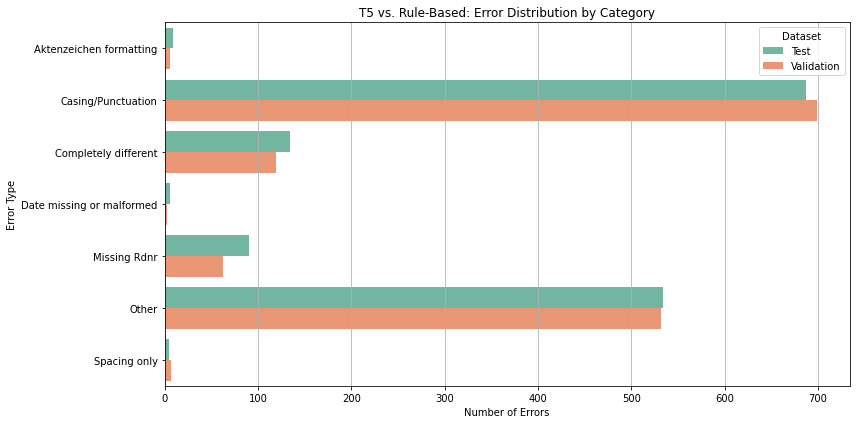

In [68]:
df_combined = pd.concat([df_diff_val, df_diff_test])
error_stats = df_combined.groupby(["Error Type", "Set"]).size().reset_index(name="Count")

plt.figure(figsize=(12, 6))
sns.barplot(data=error_stats, x="Count", y="Error Type", hue="Set", palette="Set2")
plt.title("T5 vs. Rule-Based: Error Distribution by Category")
plt.xlabel("Number of Errors")
plt.ylabel("Error Type")
plt.grid(axis="x")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


In [69]:
val_counts = df_diff_val["Error Type"].value_counts().reset_index()
val_counts.columns = ["Error Type", "Validation Count"]

test_counts = df_diff_test["Error Type"].value_counts().reset_index()
test_counts.columns = ["Error Type", "Test Count"]

error_summary = pd.merge(val_counts, test_counts, on="Error Type", how="outer").fillna(0)
error_summary["Validation Count"] = error_summary["Validation Count"].astype(int)
error_summary["Test Count"] = error_summary["Test Count"].astype(int)

error_summary["Total"] = error_summary["Validation Count"] + error_summary["Test Count"]
error_summary = error_summary.sort_values("Total", ascending=False)
error_summary.reset_index(drop=True)



,Error Type,Validation Count,Test Count,Total
0,Casing/Punctuation,699,687,1386
1,Other,532,534,1066
2,Completely different,119,134,253
3,Missing Rdnr,63,90,153
4,Aktenzeichen formatting,6,9,15
5,Spacing only,7,5,12
6,Date missing or malformed,3,6,9


In [70]:
df_other_errors = pd.concat([df_diff_val, df_diff_test])
df_other_errors = df_other_errors[df_other_errors["Error Type"] == "Other"]
pd.set_option("display.max_colwidth", None)
df_other_errors[["Raw Input", "Rule-based Output (Target)", "T5 Prediction"]].head(10)


,Raw Input,Rule-based Output (Target),T5 Prediction
1,"<B-Gericht>BVerwG </B-Gericht> , Urteil vom <B-Datum>27 . 10 . 2000 </B-Datum> - <B-Aktenzeichen>4 A 18 / 99 </B-Aktenzeichen> - in : <B-Zeitschrift>DVBl </B-Zeitschrift> . <B-Jahr>2001 </B-Jahr> , <B-Seite-Beginn>386 </B-Seite-Beginn> ff","Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 386, 2001","Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 366, 2001"
3,"<B-Gericht>BVerwG </B-Gericht> , Beschluss vom <B-Datum>29 . Mai 1990 </B-Datum> - <B-Aktenzeichen>7 B 30 / 90 </B-Aktenzeichen> - juris im Anschluss an <B-Gericht>BVerwG </B-Gericht> , Beschluss vom <B-Datum>06 . März 1990 </B-Datum> , aaO","Bundesverwaltungsgericht, Urteil vom 29.Mai 1990, - 7 B 30/90 -","Bundesverwaltungsgericht, Urteil vom 29.05.29, - 7 B 30/90 -"
7,"<B-Gericht>BAG </B-Gericht> , Urteil vom <B-Datum>01 . 08 . 2001 </B-Datum> - <B-Aktenzeichen>4 AZR 388 / 99 </B-Aktenzeichen> - zitiert nach JURIS , Rn . <B-Randnummer>34 </B-Randnummer>","BAG, Urteil vom 2001.08.01, - 4 AZR 388/99 -, Rdnr. 34","BAG, Urteil vom 2001.08.01, - 4 AZR 382/99 -, Rdnr. 34"
10,"<B-Gericht>BAG </B-Gericht> vom <B-Datum>11 . 06 . 2002 </B-Datum> - Az . <B-Aktenzeichen>1 AZR 390 / 01 </B-Aktenzeichen> - zitiert nach JURIS , Rz . <B-Randnummer>25 </B-Randnummer> , m . w . N .","BAG, Urteil vom 2002.06.11, - 1 AZR 390/01 -, Rdnr. 25","BAG, Urteil vom 2002.06.11, - 1 AZR 391/01 -, Rdnr. 25"
11,"<B-Gericht>BVerfG </B-Gericht> , Beschluss vom <B-Datum>23 . 10 . 1973 </B-Datum> - <B-Aktenzeichen>2 BvC 3 / 73 </B-Aktenzeichen> - , juris","Bundesverfassungsgericht, Urteil vom 1973.10.23, - 2 BvC 3/73 -","Bundesverfassungsgericht, Urteil vom 1973.10.13, - 2 BvC 3/73 -"
17,"<B-Gericht>OLG Dresden </B-Gericht> , <B-Zeitschrift>NJW - RR </B-Zeitschrift> <B-Jahr>2007 </B-Jahr> , <B-Seite-Beginn>1161 </B-Seite-Beginn> f . unter Bezugnahme auf <B-Autor>Zöller </B-Autor> / <B-Autor>Herget </B-Autor> , <B-Gesetz>ZPO </B-Gesetz> , <B-Auflage>26 </B-Auflage> . <B-Auflage>Auflage </B-Auflage> , <B-Paragraph>§ 3 </B-Paragraph> Stichwort "" Ehesache ""","OLG Dresden, Neue Juristische Wochenschrift - RR, 1161, 2007, Zöller/Herget, 26 age Aufl., ZPO, § 3","OLG Dresden, Neue Juristische Wochenschrift - RR, 1161, 2007, Zöller/Herget, 26 age Aufl."
18,"<B-Gericht>BGH </B-Gericht> , Urteil vom <B-Datum>13 . 07 . 2021 </B-Datum> , <B-Aktenzeichen>VI ZR 128 / 21 </B-Aktenzeichen> , Rn . <B-Randnummer>20 </B-Randnummer> ff . bei juris","Bundesgerichtshof, Urteil vom 2021.07.13, - VI ZR 128/21 -, Rdnr. 20","Bundesgerichtshof, Urteil vom 2021.07.13, - VI ZR 122/21 -, Rdnr. 20"
21,<B-Gericht>BAG </B-Gericht> v . <B-Datum>21 . 02 . 2001 </B-Datum> - <B-Aktenzeichen>2 AZR 558 / 99 </B-Aktenzeichen> - zit . nach Juris,"BAG, Urteil vom 2001.02.21, - 2 AZR 558/99 -","BAG, Urteil vom 2001.02.21, - 2 AZR 552/99 -"
22,"<B-Autor>Dienelt </B-Autor> , <B-Autor>Bergmann </B-Autor> / <B-Autor>Dienelt </B-Autor> , <B-Titel>Ausländerrecht </B-Titel> , <B-Auflage>12 </B-Auflage> . <B-Auflage>Auflage </B-Auflage> <B-Jahr>2018 </B-Jahr> , <B-Paragraph>Art . 6 </B-Paragraph> <B-Gesetz>ARB 1 / 80 </B-Gesetz> Rn . <B-Randnummer>39 </B-Randnummer>","Dienelt/Bergmann/Dienelt, Ausländerrecht, 12 age Aufl., ARB 1/80, § Art.6, Rdnr. 39, 2018","Diienelt/Bergmann/Dienelt, Ausländerrecht, 12 age Aufl., ARB 1/80, Art.6, Rdnr. 39, 2018"
27,"<B-Autor>Keidel </B-Autor> / <B-Autor>Zimmermann </B-Autor> , <B-Paragraph>§ 31 </B-Paragraph> Rn . <B-Randnummer>18 , </B-Randnummer> <B-Randnummer>20 und 22 b </B-Randnummer> , vgl . auch <B-Paragraph>§ 121 </B-Paragraph> <B-Gesetz>VwGO </B-Gesetz>","Keidel/Zimmermann, VwGO, § 31 121, Rdnr. 18 , 20 und 22 b","Keidel/Zimmermann, VwGO, 31, Rdnr. 18 , 20 und 22 b"


In [71]:
df_all_errors = pd.concat([df_diff_val, df_diff_test])
grouped_examples = []

for category in df_all_errors["Error Type"].unique():
    subset = df_all_errors[df_all_errors["Error Type"] == category].head(5)
    for _, row in subset.iterrows():
        grouped_examples.append({
            "Error Type": category,
            "Raw Input": row["Raw Input"],
            "Rule-based Target": row["Rule-based Output (Target)"],
            "T5 Prediction": row["T5 Prediction"]
        })

df_examples = pd.DataFrame(grouped_examples)
pd.set_option("display.max_colwidth", None)
df_examples

,Error Type,Raw Input,Rule-based Target,T5 Prediction
0,Casing/Punctuation,"<B-Autor>Jürgens </B-Autor> / <B-Autor>Klüsener </B-Autor> , <B-Paragraph>§ 1890 </B-Paragraph> Rn . <B-Randnummer>5 </B-Randnummer>","Jürgens/Klüsener, § 1890, Rdnr. 5","Jürgens/Klüsener, 1890, Rdnr. 5"
1,Casing/Punctuation,<B-Titel>Münch </B-Titel> . <B-Titel>Komm </B-Titel> . / <B-Autor>Henssler </B-Autor> <B-Auflage>5 </B-Auflage> . <B-Auflage>Aufl </B-Auflage> . <B-Paragraph>§ 624 </B-Paragraph> <B-Gesetz>BGB </B-Gesetz> Rn . <B-Randnummer>5 </B-Randnummer>,"Henssler, Münch Komm, 5 Aufl., BGB, § 624, Rdnr. 5","Henssler, Münch Komm, 5 Aufl., BGB, 624, Rdnr. 5"
2,Casing/Punctuation,"<B-Autor>Söfker </B-Autor> , a . a . O . , Rn . <B-Randnummer>55 </B-Randnummer> , <B-Autor>Taegen </B-Autor> , in : <B-Titel>Berliner Komm . zum </B-Titel> <B-Gesetz>BauGB </B-Gesetz> , <B-Paragraph>§ 35 </B-Paragraph> Rn . <B-Randnummer>40 </B-Randnummer>","Söfker/Taegen, Berliner Komm.zum, BauGB, § 35, Rdnr. 55 40","Söfker/Taegen, Berliner Komm.zum, BauGB, 35, Rdnr. 55 40"
3,Casing/Punctuation,"so auch <B-Gericht>VG Leipzig </B-Gericht> , B . v . <B-Datum>23 . 01 . 2019 </B-Datum> [UNK] <B-Aktenzeichen>2 L 1023 . / 18 </B-Aktenzeichen> . <B-Aktenzeichen>NC </B-Aktenzeichen> u . a . [UNK] juris Rn . <B-Randnummer>41 </B-Randnummer> und <B-Gericht>VG Schleswig </B-Gericht> B . v . <B-Datum>21 . 11 . 2019 </B-Datum> [UNK] <B-Aktenzeichen>9 C 69 / 19 </B-Aktenzeichen> , n . v . und B . v . <B-Datum>08 . 11 . 2018 </B-Datum> [UNK] <B-Aktenzeichen>9 C 60 / 16 </B-Aktenzeichen> - , juris Rn . <B-Randnummer>86 </B-Randnummer> ff zur Univ . Kiel , bei der ebenfalls in Einzelfällen geringere Gruppengrößen als empfohlen angesetzt sind","VG Leipzig, Urteil vom 2019.01.23, - 2 L 1023./18 -, Rdnr. 41 86","VG Leipzig, Urteil vom 2019.01.23, - 2 L 1023/18 -, Rdnr. 41 86"
4,Casing/Punctuation,"so jedenfalls zu <B-Paragraph>Art . 16 Abs . 2 Satz 2 </B-Paragraph> <B-Gesetz>GG </B-Gesetz> a . F . : <B-Gericht>BVerwG </B-Gericht> vom <B-Datum>15 . 05 . 1984 </B-Datum> - <B-Aktenzeichen>1 C 59 / 81 </B-Aktenzeichen> - , <B-Zeitschrift>NVwZ </B-Zeitschrift> <B-Jahr>1984 </B-Jahr> , <B-Seite-Beginn>591 </B-Seite-Beginn>","Bundesverwaltungsgericht, Urteil vom 1984.05.15, - 1 C 59/81 -, Neue Zeitschrift für Verwaltungsrecht, 591, 1984, GG, § Art.16 Abs.2 Satz 2","Bundesverwaltungsgericht, Urteil vom 1984.05.15, - 1 C 59/81 -, Neue Zeitschrift für Verwaltungsrecht, 591, 1984, GG, Art.16 Abs.2 Satz 2"
5,Other,"<B-Gericht>BVerwG </B-Gericht> , Urteil vom <B-Datum>27 . 10 . 2000 </B-Datum> - <B-Aktenzeichen>4 A 18 / 99 </B-Aktenzeichen> - in : <B-Zeitschrift>DVBl </B-Zeitschrift> . <B-Jahr>2001 </B-Jahr> , <B-Seite-Beginn>386 </B-Seite-Beginn> ff","Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 386, 2001","Bundesverwaltungsgericht, Urteil vom 2000.10.27, - 4 A 18/99 -, DVBl, 366, 2001"
6,Other,"<B-Gericht>BVerwG </B-Gericht> , Beschluss vom <B-Datum>29 . Mai 1990 </B-Datum> - <B-Aktenzeichen>7 B 30 / 90 </B-Aktenzeichen> - juris im Anschluss an <B-Gericht>BVerwG </B-Gericht> , Beschluss vom <B-Datum>06 . März 1990 </B-Datum> , aaO","Bundesverwaltungsgericht, Urteil vom 29.Mai 1990, - 7 B 30/90 -","Bundesverwaltungsgericht, Urteil vom 29.05.29, - 7 B 30/90 -"
7,Other,"<B-Gericht>BAG </B-Gericht> , Urteil vom <B-Datum>01 . 08 . 2001 </B-Datum> - <B-Aktenzeichen>4 AZR 388 / 99 </B-Aktenzeichen> - zitiert nach JURIS , Rn . <B-Randnummer>34 </B-Randnummer>","BAG, Urteil vom 2001.08.01, - 4 AZR 388/99 -, Rdnr. 34","BAG, Urteil vom 2001.08.01, - 4 AZR 382/99 -, Rdnr. 34"
8,Other,"<B-Gericht>BAG </B-Gericht> vom <B-Datum>11 . 06 . 2002 </B-Datum> - Az . <B-Aktenzeichen>1 AZR 390 / 01 </B-Aktenzeichen> - zitiert nach JURIS , Rz . <B-Randnummer>25 </B-Randnummer> , m . w . N .","BAG, Urteil vom 2002.06.11, - 1 AZR 390/01 -, Rdnr. 25","BAG, Urteil vom 2002.06.11, - 1 AZR 391/01 -, Rdnr. 25"
9,Other,"<B-Gericht>BVerfG </B-Gericht> , Beschluss vom <B-Datum>23 . 10 . 1973 </B-Datum> - <B-